/opt/anaconda3/lib/python3.12/site-packages/pymc/data.py:235: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, obs_sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


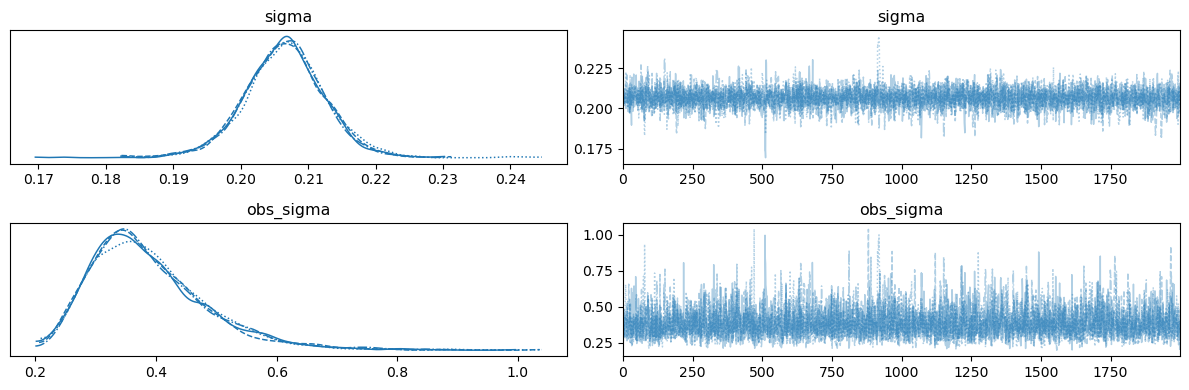

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
sigma  0.2065  0.006  0.1952   0.2176     0.0001   0.0001  3719.3427   

        ess_tail  r_hat  
sigma  3360.6477  1.001  


In [1]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy.stats import norm


S  = 100.0                    # stock price
r  = 0.01                     # risk-free rate
T  = 0.5                      # time to maturity (yrs)
K  = np.linspace(80, 120, 10) # strikes
true_sigma = 0.20

def bs_call_price_np(S, K, T, r, sigma):
    d1 = (np.log(S/K)+(r+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

C_obs = bs_call_price_np(S, K, T, r, true_sigma)
C_obs += np.random.normal(0, 0.25, size=K.shape)

# ---------- Bayesian calibration ----------
with pm.Model() as model:

    K_data = pm.ConstantData("K_data", K)
    
    sigma = pm.HalfNormal("sigma", sigma=1.0)
    obs_sigma = pm.HalfNormal("obs_sigma", sigma=0.5)
    
    def Phi(x):
        return 0.5 * (1.0 + pm.math.erf(x / pm.math.sqrt(2.0)))
    
    # Black-Scholes call price computed symbolically
    d1 = (pm.math.log(S / K_data) + (r + 0.5 * sigma**2) * T) / (sigma * pm.math.sqrt(T))
    d2 = d1 - sigma * pm.math.sqrt(T)
    C_model = S * Phi(d1) - K_data * pm.math.exp(-r * T) * Phi(d2)
    
    # observation noise (learn it or fix it)

    pm.Normal("C_obs", mu=C_model, sigma=obs_sigma, observed=C_obs)
    
    trace = pm.sample(draws=2000, tune=2000, target_accept=0.95, return_inferencedata=True)

# ---------- diagnostics ----------
az.plot_trace(trace)
plt.tight_layout(); plt.show()

print(az.summary(trace, var_names=["sigma"], round_to=4))